# Defining a Custom Distribution in PyMC3

:::{post} Sept 19, 2021
:tags: exploratory analysis, pymc3.AR, pymc3.HalfNormal, pymc3.Model, pymc3.Normal, pymc3.TruncatedNormal
:category: intermediate
:::

In this notebook, we are going to walk through how to create a custom distribution for the Generalized Poisson distribution.

There are 3 main steps required to define a custom distribution in PyMC3:
1. Define the log probability function
2. Define the random generator function
3. Define the class for the distribution

## Background on the Generalized Poisson

The **Poisson** distribution models equidispersed count data where the mean $\mu$ is equal to the variance.
$$p(Y = y | \mu ) = \frac{e^{-\mu} \mu^y}{y!}$$

The **Negative Binomial** distribution allows us to model overdispersed count data. It has 2 parameters:
- Mean $\mu > 0$
- Overdisperson parameter $\alpha > 0$
    - As $\alpha \rightarrow \infty$, the Negative Binonimal converges to the Poisson.

The **Generalized Poisson** distribution is flexible enough to handle both overdispersion and underdispersion. It has the following PMF:

$$p(Y = y | \theta, \lambda) = \frac{\theta (\theta + \lambda y)^{y-1} e^{-\theta - \lambda y}}{y!}, y = 0,1,2,...$$

where $\theta > 0$ and $\max(-1, -\frac{\theta}{4}) \leq \lambda \leq 1$

The mean and variance are given by
$$\mathbb{E}[Y] = \frac{\theta}{1 - \lambda}, \quad
\text{Var}[Y] = \frac{\theta}{(1 - \lambda)^3}$$

- When $\lambda = 0$, the Generalized Poisson reduces to the standard Poisson with $\mu = \theta$.
- When $\lambda < 0$, the model has underdispersion (mean $>$ variance).
- When $\lambda > 0$, the model has overdispersion (mean $<$ variance).

In [1]:
import os

from datetime import date, timedelta

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import theano.tensor as tt

from pymc3.distributions.dist_math import bound, factln, logpow
from pymc3.distributions.distribution import draw_values, generate_samples
from pymc3.theanof import intX

print(f"Running on PyMC3 v{pm.__version__}")

Running on PyMC3 v3.11.2


In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

## 1. Log Probability Function

The $\log$ of the PMF above is as follows:

$$\log f(y | \theta, \lambda) = \log\theta + \log\left((\theta + \lambda y)^{y-1}\right) - (\theta + \lambda y) - \log(y!),\,y = 0,1,2,...$$

where $\theta > 0$ and $\max(-1, -\frac{\theta}{4}) \leq \lambda \leq 1$

We now define the log probability function, which is an implementation of the above formula using just Aesara operations.

Parameters:
- `theta`: $\theta$
- `lam`: $\lambda$
- `value`: $y$

Returns:
- The log probability of the Generalized Poisson with the given parameters, evaluated at the specified value.

In [3]:
def genpoisson_logp(theta, lam, value):
    theta_lam_value = theta + lam * value
    log_prob = np.log(theta) + logpow(theta_lam_value, value - 1) - theta_lam_value - factln(value)

    # Probability is 0 when value > m, where m is the largest positive integer for which
    # theta + m * lam > 0 (when lam < 0).
    log_prob = tt.switch(theta_lam_value <= 0, -np.inf, log_prob)

    return bound(log_prob, value >= 0, theta > 0, abs(lam) <= 1, -theta / 4 <= lam)

## 2. Generator Function

If your distribution exists in [`scipy.stats`](https://docs.scipy.org/doc/scipy/reference/stats.html), then you can use the Random Variates method `scipy.stats.{dist_name}.rvs` to generate random samples.

Since `scipy` does not include the Generalized Poisson, we will define our own generator function using the Inversion Algorithm presented in {cite:t}`famoye1997randomvariate`:

Initialize $\omega \leftarrow e^{-\lambda}$
1. $X \leftarrow 0$
2. $S \leftarrow e^{-\theta}$ and $P \leftarrow S$
3. Generate $U$ from uniform distribution on $(0,1)$.
4. While $U > S$, do
    1. $X \leftarrow X + 1$
    2. $C \leftarrow \theta - \lambda + \lambda X$
    3. $P \leftarrow \omega \cdot C (1 + \frac{\lambda}{C})^{X-1} P X^{-1}$
    4. $S \leftarrow S + P$
5. Deliver $X$

We now define a function that generates a set of random samples from the Generalized Poisson with the given parameters. It is meant to be analogous to `scipy.stats.{dist_name}.rvs`.

Parameters:
- `theta`: An array of values for $\theta$
- `lam`: A single value for $\lambda$
- `size`: The number of samples to generate

Returns:
- One random sample for the Generalized Poisson defined by each of the given $\theta$ values and the given $\lambda$ value.

In [4]:
def genpoisson_rvs(theta, lam, size=None):
    if size is not None:
        assert size == theta.shape
    else:
        size = theta.shape
    lam = lam[0]
    omega = np.exp(-lam)
    X = np.full(size, 0)
    S = np.exp(-theta)
    P = np.copy(S)
    for i in range(size[0]):
        U = rng.uniform()
        while U > S[i]:
            X[i] += 1
            C = theta[i] - lam + lam * X[i]
            P[i] = omega * C * (1 + lam / C) ** (X[i] - 1) * P[i] / X[i]
            S[i] += P[i]
    return X

## 3. Class Definition

Every PyMC3 distribution requires the following basic format. A few things to keep in mind:
- Your class should have the parent class `pm.Discrete` if your distribution is discrete, or `pm.Continuous` if your distriution is continuous.
- For continuous distributions you also have to define the default transform, or inherit from a more specific class like `PositiveContinuous` which specifies what the default transform should be.
- You'll need specify at least one "default value" for the distribution during `init` such as `self.mode`, `self.median`, or `self.mean` (the latter only for continuous distributions). This is used by some samplers or other compound distributions.

In [5]:
class GenPoisson(pm.Discrete):
    def __init__(self, theta, lam, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.theta = theta
        self.lam = lam
        self.mode = intX(tt.floor(theta / (1 - lam)))

    def logp(self, value):
        theta = self.theta
        lam = self.lam
        return genpoisson_logp(theta, lam, value)

    def random(self, point=None, size=None):
        theta, lam = draw_values([self.theta, self.lam], point=point, size=size)
        return generate_samples(genpoisson_rvs, theta=theta, lam=lam, size=size)

## Sanity Check

Let's sample from our new distribution to make sure it's working as expected. We'll take 5000 samples each from the standard Poisson, the Generalized Poisson (GP) with $\lambda=0$, the GP with $\lambda<0$, and the GP with $\lambda>0$. You can see that the GP with $\lambda=0$ is equivalent to the standard Poisson (mean $=$ variance), while the GP with $\lambda<0$ is underdispered (mean $>$ variance), and the GP with $\lambda>0$ is overdispersed (mean $<$ variance).

In [6]:
std = pm.Poisson.dist(mu=5).random(size=5000)
equi = GenPoisson.dist(theta=np.full(5000, 5), lam=0).random()
under = GenPoisson.dist(theta=np.full(5000, 5), lam=-0.5).random()
over = GenPoisson.dist(theta=np.full(5000, 5), lam=0.3).random()

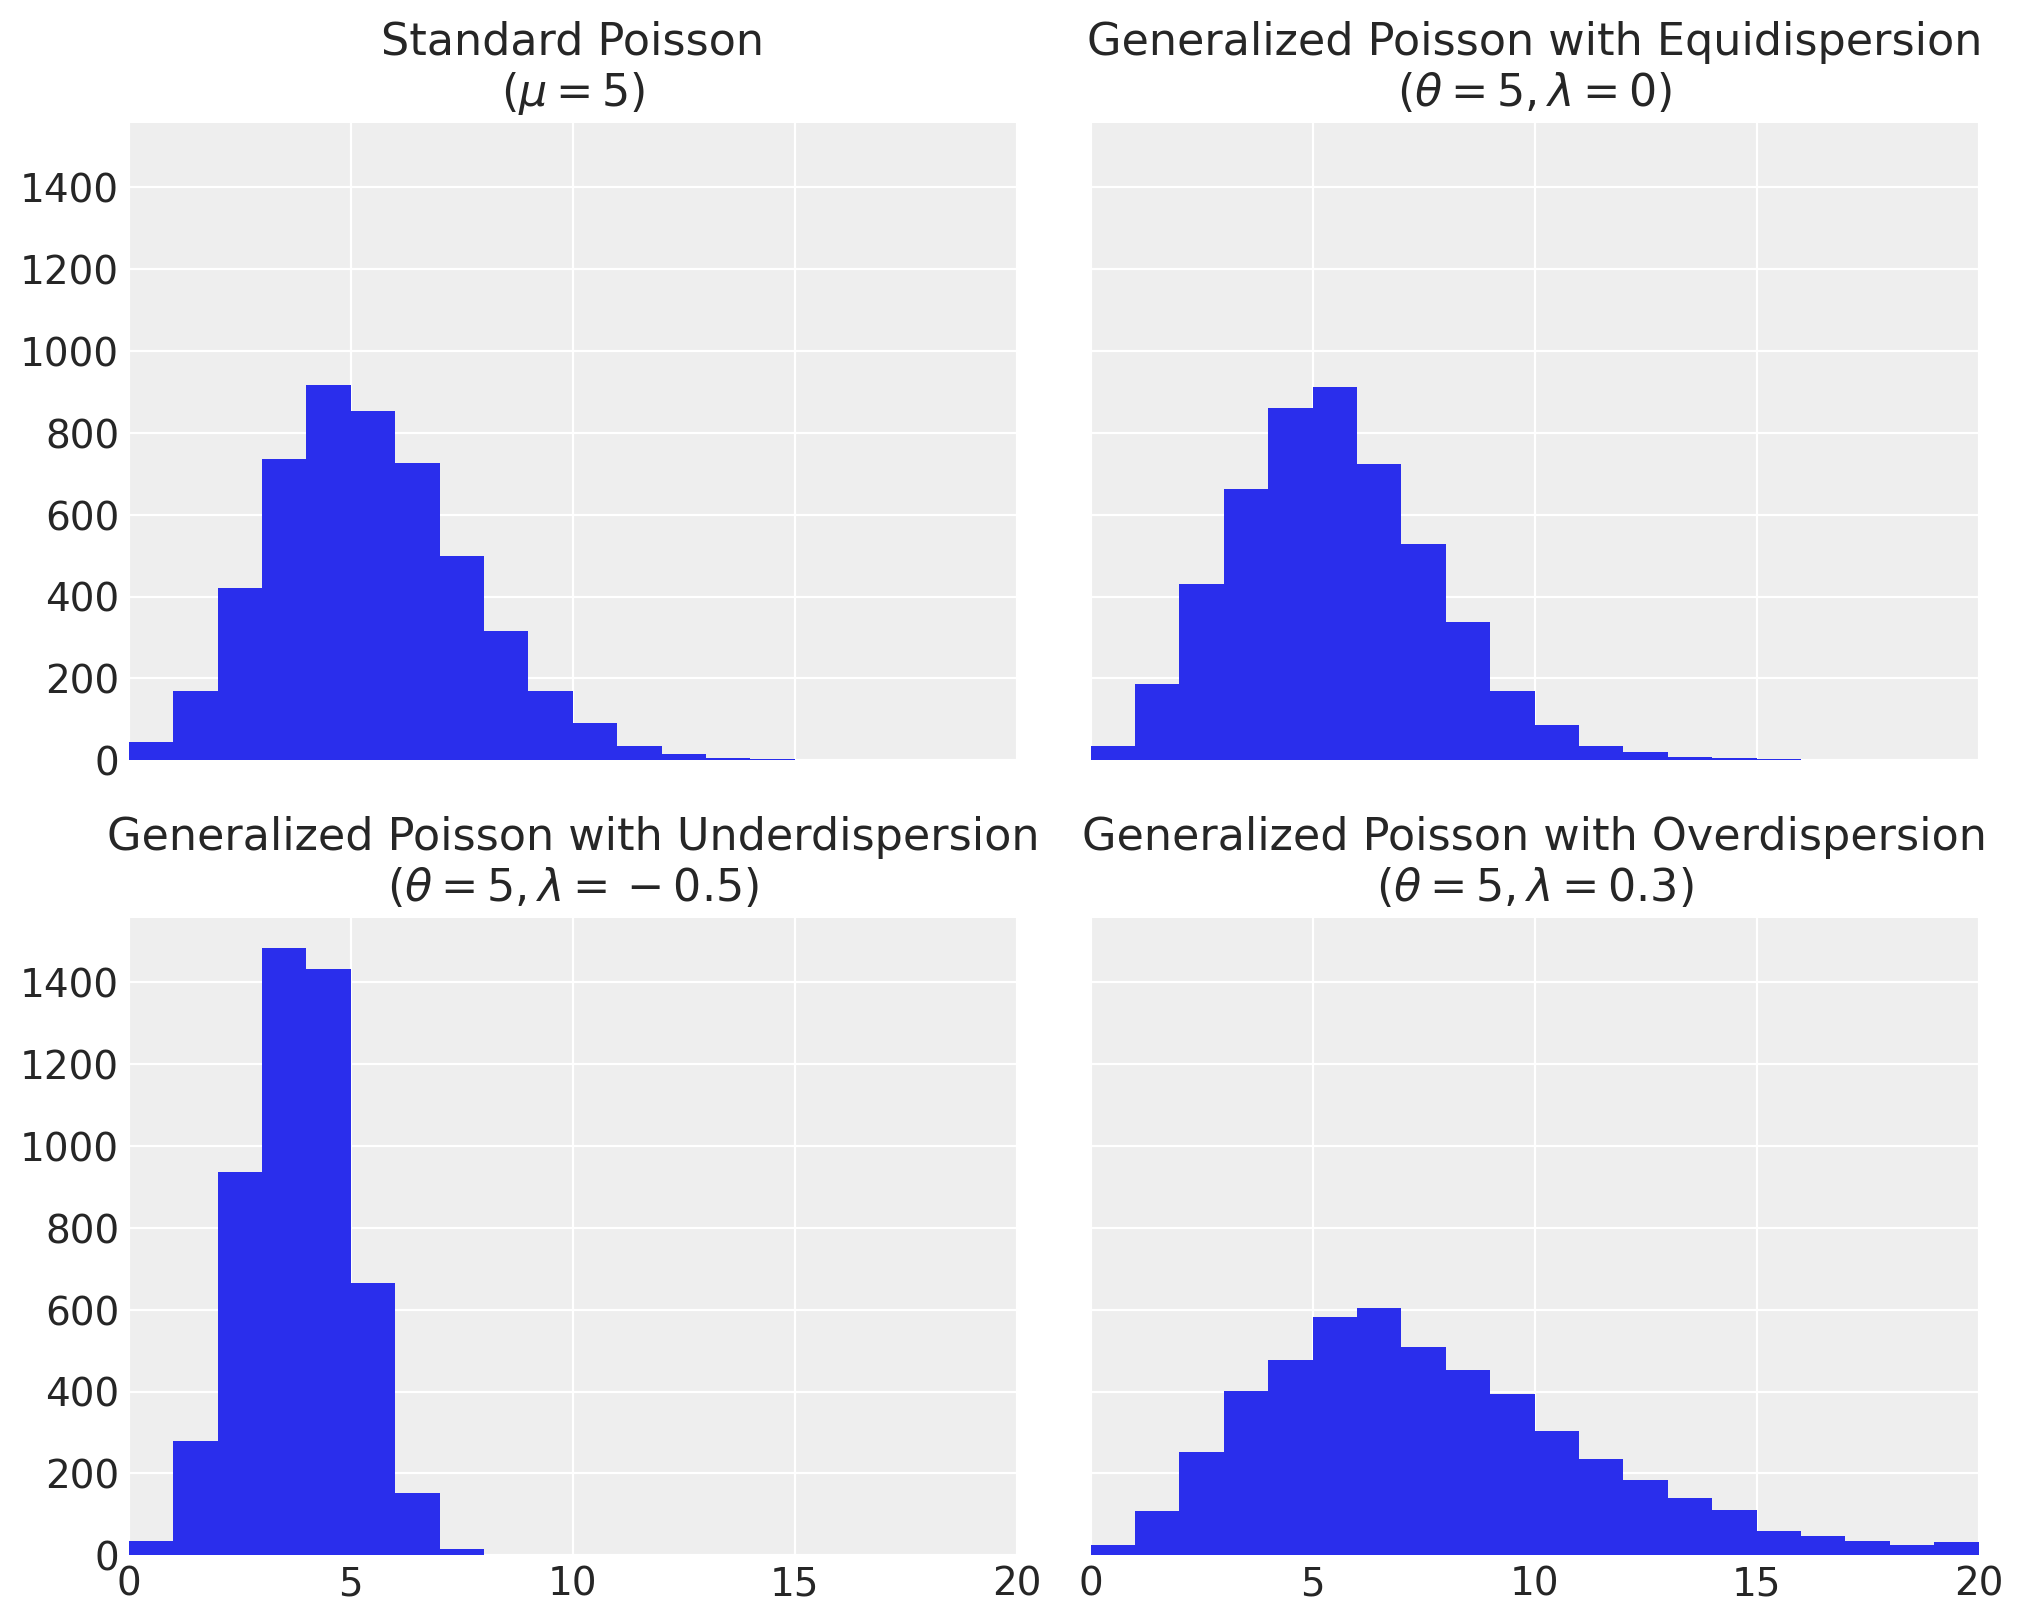

In [7]:
fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(10, 8))
plt.setp(ax, xlim=(0, 20))

ax[0][0].hist(std, bins=np.arange(21))
ax[0][0].set_title("Standard Poisson\n($\\mu=5$)")

ax[0][1].hist(equi, bins=np.arange(21))
ax[0][1].set_title("Generalized Poisson with Equidispersion\n($\\theta=5, \\lambda=0$)")

ax[1][0].hist(under, bins=np.arange(21))
ax[1][0].set_title("Generalized Poisson with Underdispersion\n($\\theta=5, \\lambda=-0.5$)")

ax[1][1].hist(over, bins=np.arange(21))
ax[1][1].set_title("Generalized Poisson with Overdispersion\n($\\theta=5, \\lambda=0.3$)");

## Using our custom distribution in our model

Now that we have defined our custom distribution, we can use it in our PyMC3 model as we would use any other pre-defined distribution.

### Model

Our goal is to predict the next 2 weeks of COVID-19 occupancy counts at a specific hospital. We are given a series of daily counts $y_t$ indexed by day $t$ for the past $T$ days, and we would like to make forecasts for the next $F=14$ days. In other words, we are building a probabilisitic model for

$$p( y_{(T+1):(T+F)} \mid y_{1:T} )$$

We suppose that $y$ is GenPoisson-distributed over the exponential of a latent time series $f$, where $f$ is an autoregressive process with 1 lag, i.e., for each day $t$,

$$y_t \sim \text{GenPoisson}( \theta = \exp(f_t), \lambda )$$

$$f_t \sim N(\beta_0 + \beta_1 * f_{t-1}, \sigma^2)$$

### Priors
- Bias weight: 

$$\beta_0 \sim N(0,0.1)$$
                
- Weight on most recent timestep: 

$$\beta_1 \sim N(1,0.1)$$


- Standard deviation: 

$$\sigma \sim \text{HalfNormal}(0.1)$$


- Dispersion parameter: 

$$\lambda \sim \text{TruncatedNormal}(0, 0.1, \text{lower}=-1, \text{upper}=1)$$

In [8]:
try:
    df = pd.read_csv(
        os.path.join("..", "data", "tufts_medical_center_2020-04-29_to_2020-07-06.csv")
    )
except FileNotFoundError:
    df = pd.read_csv(pm.get_data("tufts_medical_center_2020-04-29_to_2020-07-06.csv"))

dates = df["date"].values
y = df["hospitalized_total_covid_patients_suspected_and_confirmed_including_icu"].astype(float)

We'll divide our dataset into training and validation sets, holding out the last $F=14$ days, and treating the remaining $T$ days as the past.

In [9]:
F = 14
T = len(y) - F
y_tr = y[:T]
y_va = y[-F:]

In [10]:
coords = {
    "total_days": np.arange(len(y)),
    "observed_days": np.arange(len(y_tr)),
    "future_days": np.arange(len(y_va)),
}

with pm.Model(coords=coords) as model:
    bias = pm.Normal("beta[0]", mu=0, sigma=0.1)
    beta_recent = pm.Normal("beta[1]", mu=1, sigma=0.1)
    rho = [bias, beta_recent]
    sigma = pm.HalfNormal("sigma", sigma=0.1)
    f = pm.AR("f", rho, sigma=sigma, constant=True, dims="total_days")

    lam = pm.TruncatedNormal("lam", mu=0, sigma=0.1, lower=-1, upper=1)

    y_past = GenPoisson("y_past", theta=tt.exp(f[:T]), lam=lam, observed=y_tr, dims="observed_days")

In [11]:
with model:
    trace = pm.sample(
        5000,
        tune=2000,
        target_accept=0.99,
        max_treedepth=15,
        chains=2,
        cores=1,
        init="adapt_diag",
        random_seed=42,
        return_inferencedata=True,
    )

/home/ada/.local/lib/python3.8/site-packages/theano/tensor/elemwise.py:826: RuntimeWarning: divide by zero encountered in log1p
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
/home/ada/.local/lib/python3.8/site-packages/theano/tensor/elemwise.py:826: RuntimeWarning: divide by zero encountered in log1p
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/home/ada/.local/lib/python3.8/site-packages/theano/tensor/elemwise.py:826: RuntimeWarning: divide by zero encountered in log1p
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Sequential sampling (2 chains in 1 job)
NUTS: [lam, f, sigma, beta[1], beta[0]]


Sampling 2 chains for 2_000 tune and 5_000 draw iterations (4_000 + 10_000 draws total) took 584 seconds.


0, dim: observed_days, 55 =? 55


The number of effective samples is smaller than 10% for some parameters.


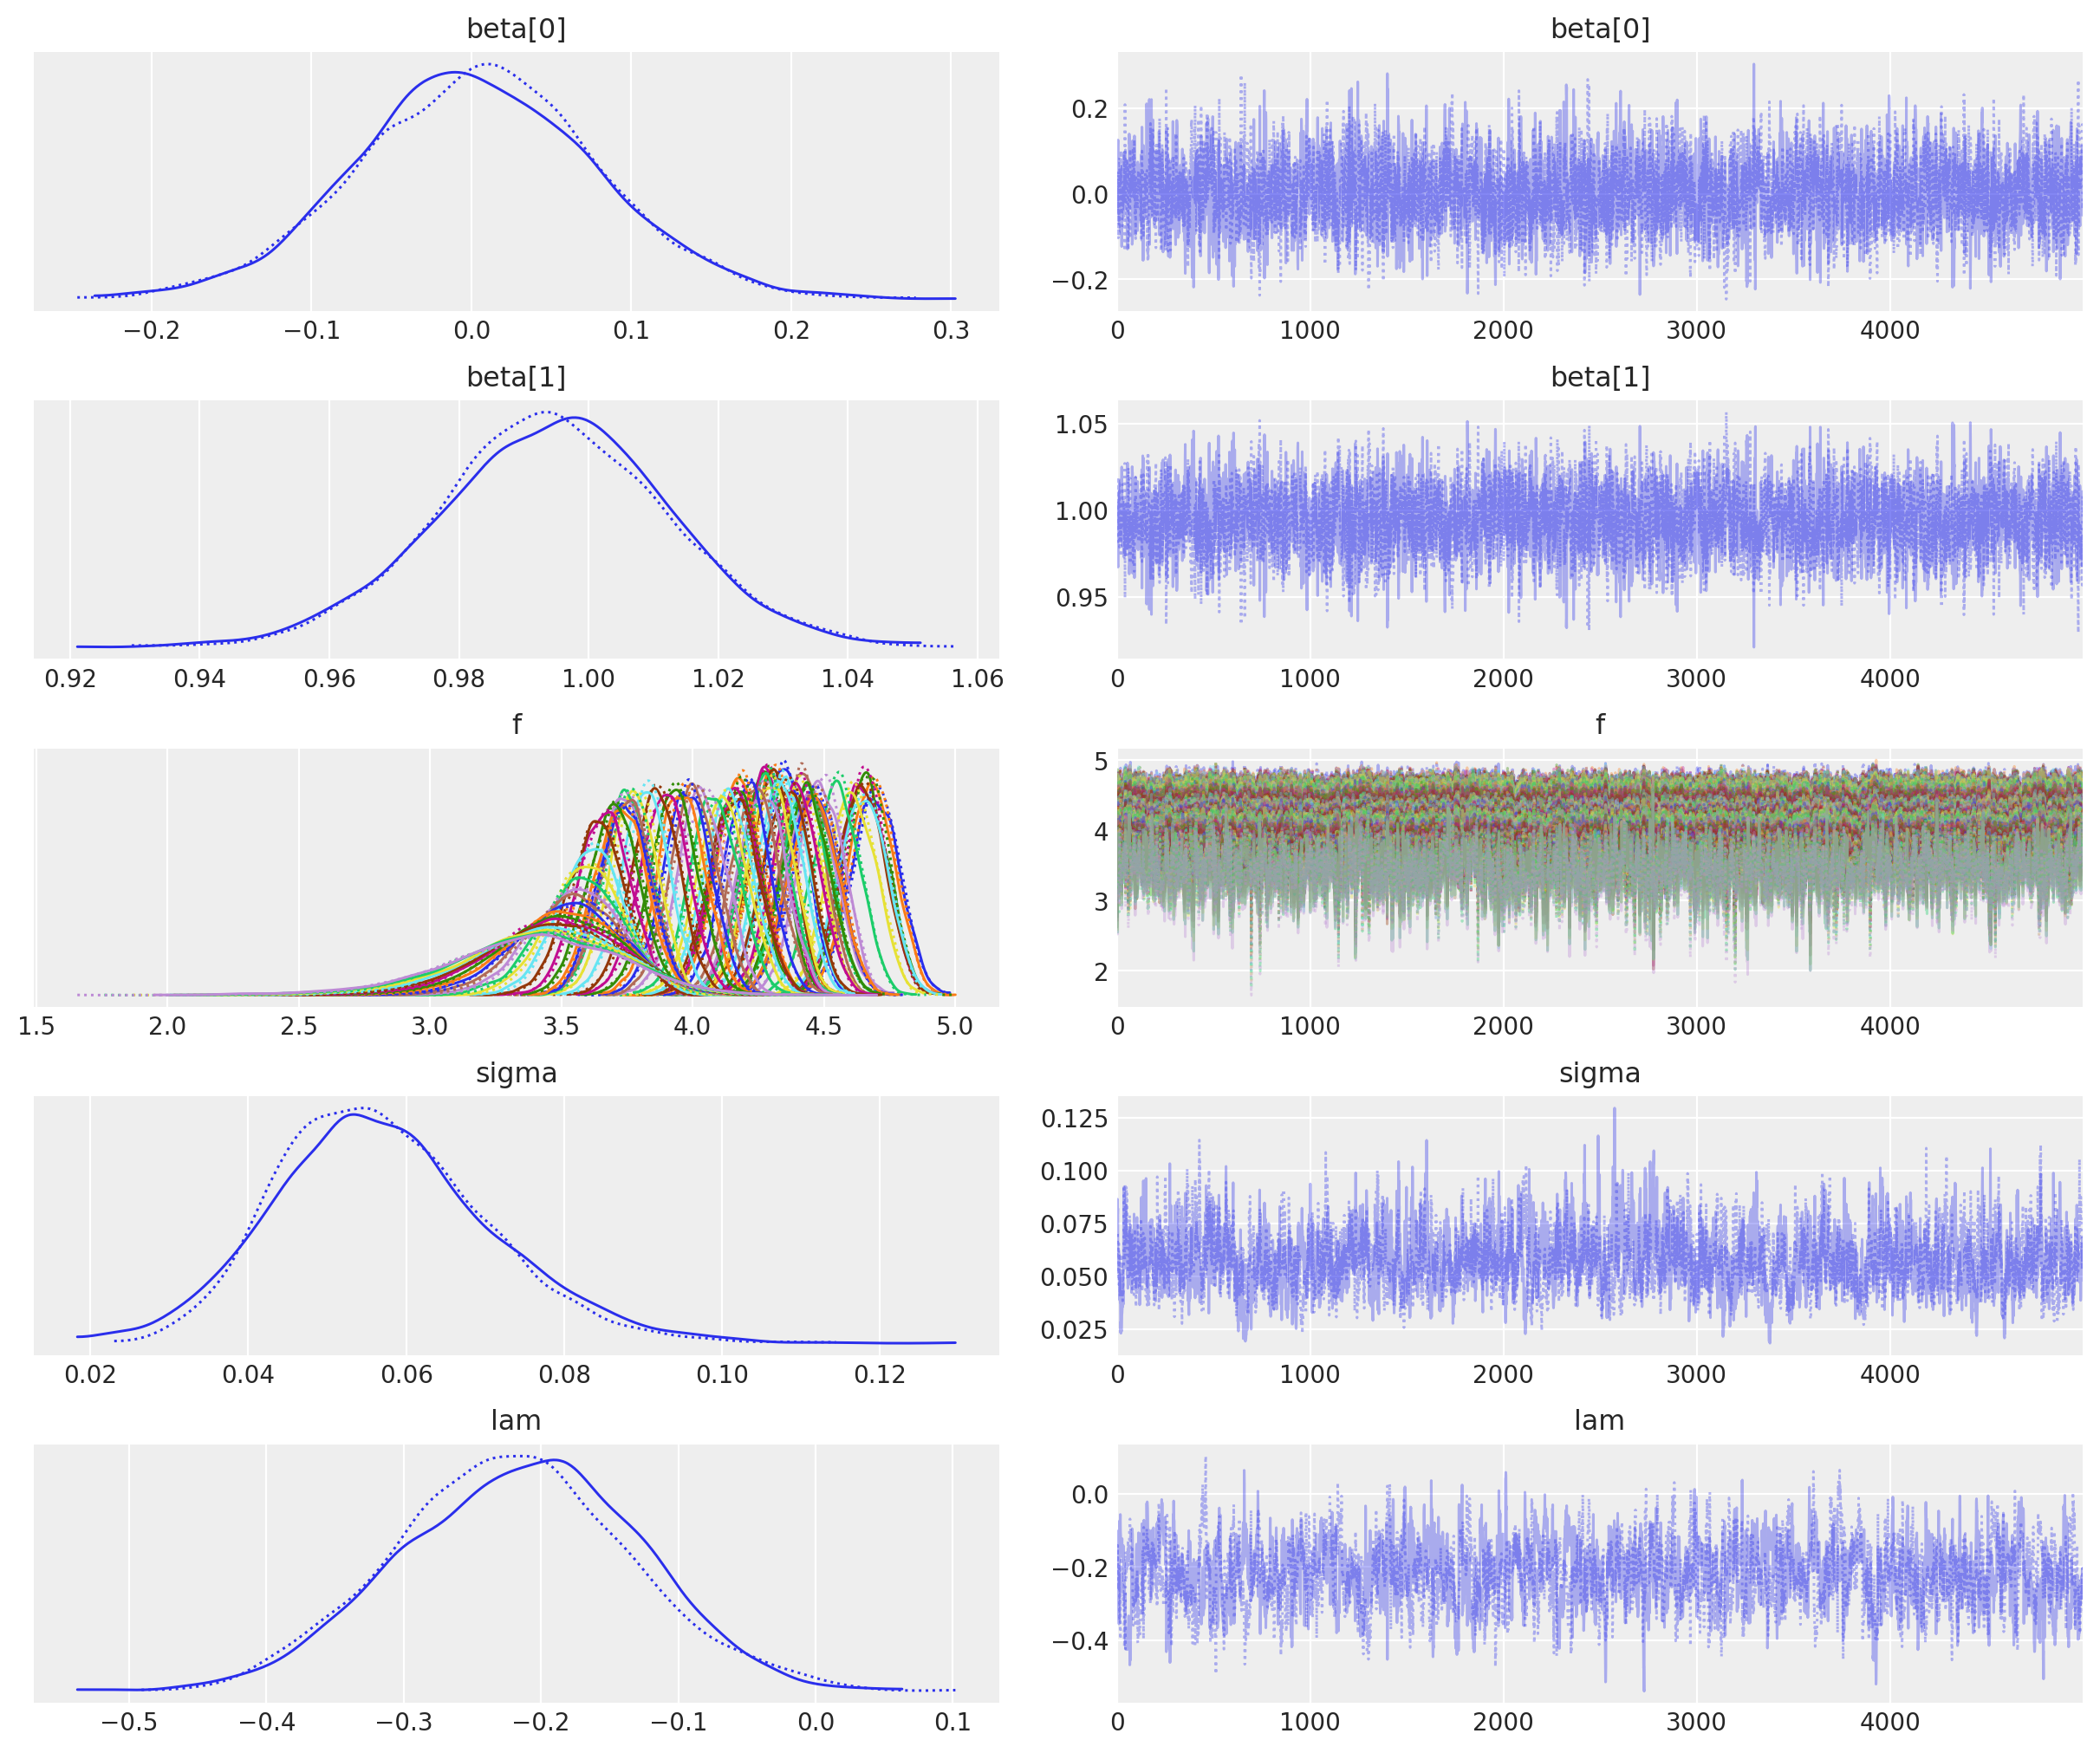

In [12]:
az.plot_trace(trace);

In [13]:
with model:
    y_future = GenPoisson("y_future", theta=tt.exp(f[-F:]), lam=lam, dims="future_days")
    forecasts = pm.sample_posterior_predictive(trace, var_names=["y_future"], random_seed=42)

trace.extend(az.from_pymc3(posterior_predictive=forecasts, model=model))

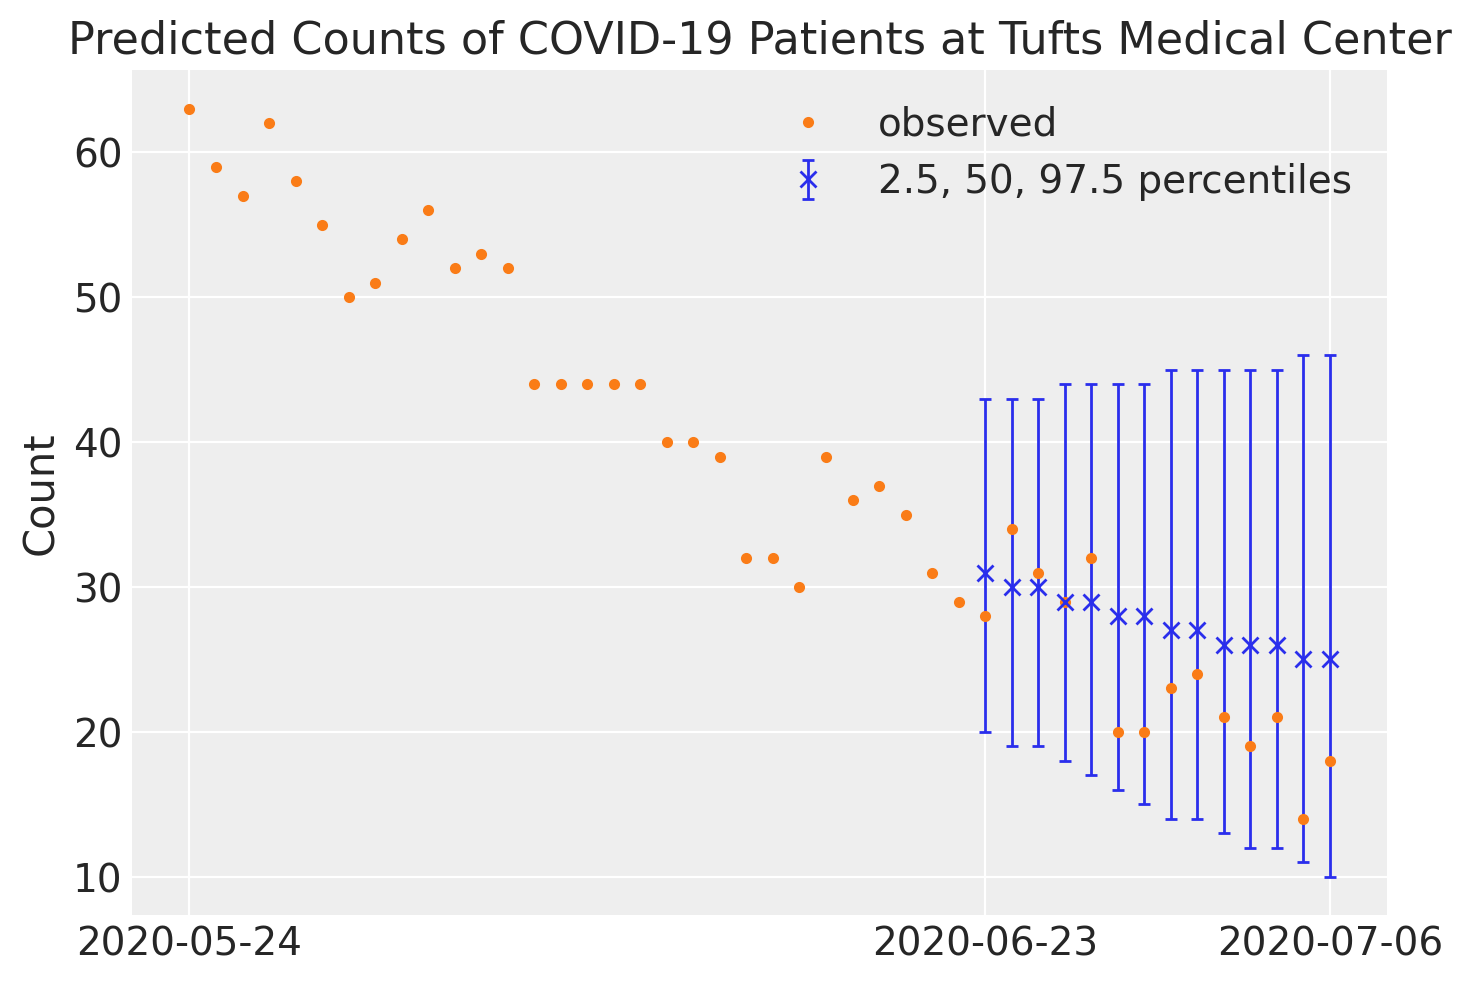

In [14]:
start = date.fromisoformat(dates[-1]) - timedelta(F - 1)  # start date of forecasts

qs = trace.posterior_predictive["y_future"].quantile((0.025, 0.5, 0.975), dim=("chain", "draw"))
low = qs.sel(quantile=0.025)
median = qs.sel(quantile=0.5)
high = qs.sel(quantile=0.975)

x_future = np.arange(F)
plt.errorbar(
    x_future,
    median,
    yerr=[median - low, high - median],
    capsize=2,
    fmt="x",
    linewidth=1,
    label="2.5, 50, 97.5 percentiles",
)
x_past = np.arange(-30, 0)

plt.plot(
    np.concatenate((x_past, x_future)), np.concatenate((y_tr[-30:], y_va)), ".", label="observed"
)

plt.xticks([-30, 0, F - 1], [start + timedelta(-30), start, start + timedelta(F - 1)])

plt.legend()
plt.title("Predicted Counts of COVID-19 Patients at Tufts Medical Center")
plt.ylabel("Count")
plt.show()

Author: Alexandra Hope Lee.

## References

:::{bibliography}
:filter: docname in docnames

lee2021forecasting
consul1992generalizedpoisson
harris2012undispersedcountdata
:::

## Watermark

In [15]:
%load_ext watermark
%watermark -n -u -v -iv -w -p xarray

Last updated: Thu Sep 09 2021

Python implementation: CPython
Python version       : 3.8.10
IPython version      : 7.25.0

xarray: 0.17.0

arviz     : 0.11.2
matplotlib: 3.3.4
pandas    : 1.2.1
numpy     : 1.21.0
pymc3     : 3.11.2
theano    : 1.1.2

Watermark: 2.2.0

